In [1]:
import pandas as pd
from matplotlib import rcParams
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import warnings

warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_csv('data/교량_통합_정제_2.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5680 entries, 0 to 5679
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   교량명        5680 non-null   object 
 1   시설물종별등급구분  5680 non-null   object 
 2   교량연장       5680 non-null   float64
 3   교량폭        5680 non-null   float64
 4   차로수        5680 non-null   int64  
 5   상부구조형식     5680 non-null   object 
 6   최종안전점검결과   5680 non-null   object 
 7   설계활하중      5680 non-null   object 
 8   준공후경과년수    5680 non-null   int64  
 9   경간수        5680 non-null   float64
 10  최대경간장      5680 non-null   float64
 11  교통량        5680 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 532.6+ KB


# 랜덤 포레스트

### 모든 변수, 독립변수 더미 변수화

In [36]:
# 독립변수와 종속변수 분리
X = df.drop(['교량명', '최종안전점검결과'], axis=1)
y = df['최종안전점검결과']

# 범주형 변수를 더미(dummy) 변수로 변환
X = pd.get_dummies(X)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 랜덤 포레스트 모델 생성
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# 모델 학습
rf.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = rf.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8603286384976526


In [37]:
importances = rf.feature_importances_
feature_names = X.columns

# 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 중요도 기준으로 내림차순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False, ignore_index=True)

# 중요도 출력
top_10_importance = importance_df.head(10)
top_10_importance

,Feature,Importance
0,준공후경과년수,0.231333
1,교통량,0.156792
2,교량폭,0.138126
3,교량연장,0.114556
4,최대경간장,0.104761
5,차로수,0.054074
6,경간수,0.053176
7,시설물종별등급구분_기타,0.031969
8,상부구조형식_PSCI거더교,0.013231
9,시설물종별등급구분_3,0.012084


### 모든 변수, 독립변수 더미 변수화, 그리드 탐색

In [38]:
# 독립변수와 종속변수 분리
X = df.drop(['교량명', '최종안전점검결과'], axis=1)  # 독립변수
y = df['최종안전점검결과']  # 종속변수

# 범주형 변수를 더미(dummy) 변수로 변환
X = pd.get_dummies(X)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 탐색할 하이퍼파라미터의 조합 정의
param_grid = {
    'n_estimators': [100, 200, 300],  # 트리 개수
    'max_depth': [None, 5, 10],  # 트리의 깊이
    'min_samples_split': [2, 5, 10],  # 분할을 위한 최소 샘플 수
}

# 랜덤 포레스트 분류기 객체 생성
rf = RandomForestClassifier(random_state=42)

# 그리드 탐색 객체 생성
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# 그리드 탐색 수행
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 조합과 평가 점수 출력
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# 최적의 하이퍼파라미터로 랜덤 포레스트 모델 구축
best_rf = RandomForestClassifier(**grid_search.best_params_)
best_rf.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = best_rf.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best parameters:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best score:  0.869715874972346
Accuracy: 0.8609154929577465


In [39]:
# 중요도 계산
importances = best_rf.feature_importances_

# 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# 중요도 기준으로 내림차순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False, ignore_index=True)

# 상위 10개 변수 출력
top_10_importance = importance_df.head(10)
top_10_importance

,Feature,Importance
0,준공후경과년수,0.230857
1,교통량,0.158242
2,교량폭,0.138670
3,교량연장,0.119170
4,최대경간장,0.103062
5,경간수,0.053424
6,차로수,0.052555
7,시설물종별등급구분_기타,0.027559
8,상부구조형식_PSCI거더교,0.012533
9,시설물종별등급구분_3,0.011930


### 모든 변수, 독립변수 라벨 인코딩, 그리드 탐색

In [14]:
# 독립변수와 종속변수 분리
X = df.drop(['교량명', '최종안전점검결과'], axis=1)  # 독립변수
y = df['최종안전점검결과']  # 종속변수

# 범주형 변수 라벨 인코딩
label_encoder = LabelEncoder()
X_encoded = X.copy()
for column in X.columns:
    if X[column].dtype == "object":
        X_encoded[column] = label_encoder.fit_transform(X[column])

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# 탐색할 하이퍼파라미터의 조합 정의
param_grid = {
    'n_estimators': [100, 200, 300],  # 트리 개수
    'max_depth': [i for i in range(1, 11)],  # 트리의 깊이
    'min_samples_leaf' : [i for i in range(10)]  # 노드가 되기 위한 최소 샘플 수 
}
    
# 랜덤 포레스트 분류기 객체 생성
rf = RandomForestClassifier(random_state=42)

# 그리드 탐색 객체 생성
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# 그리드 탐색 수행
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 조합과 평가 점수 출력
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# 최적의 하이퍼파라미터로 랜덤 포레스트 모델 구축
best_rf = RandomForestClassifier(**grid_search.best_params_)
best_rf.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = best_rf.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}
Best score:  0.8641831800511994
Accuracy: 0.8556338028169014


In [15]:
# 중요도 계산
importances = best_rf.feature_importances_

# 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# 중요도 기준으로 내림차순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False, ignore_index=True)

# 상위 10개 변수 출력
top_10_importance = importance_df.head(10)
top_10_importance

,Feature,Importance
0,준공후경과년수,0.305106
1,교통량,0.160619
2,교량연장,0.108607
3,교량폭,0.108249
4,최대경간장,0.091544
5,시설물종별등급구분,0.070175
6,경간수,0.055676
7,상부구조형식,0.045693
8,차로수,0.043102
9,설계활하중,0.011228


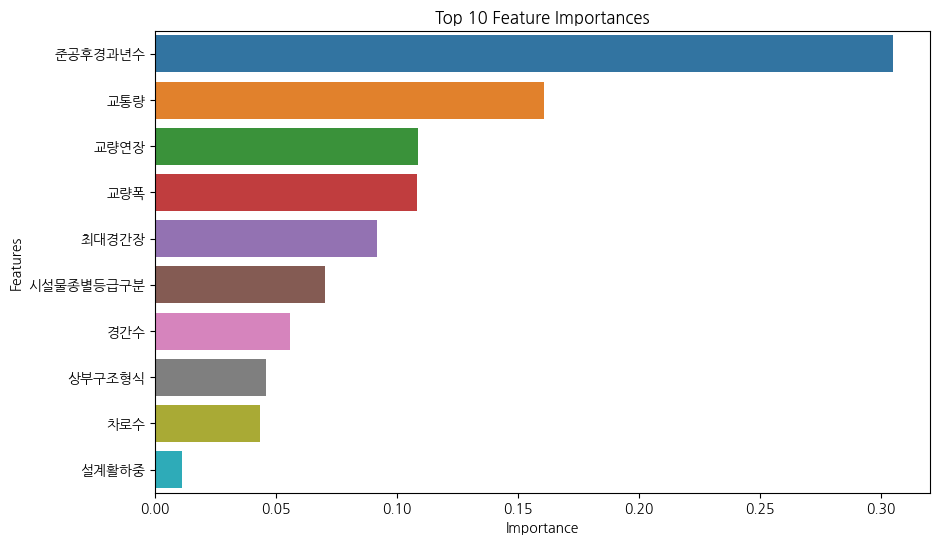

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_importance)
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

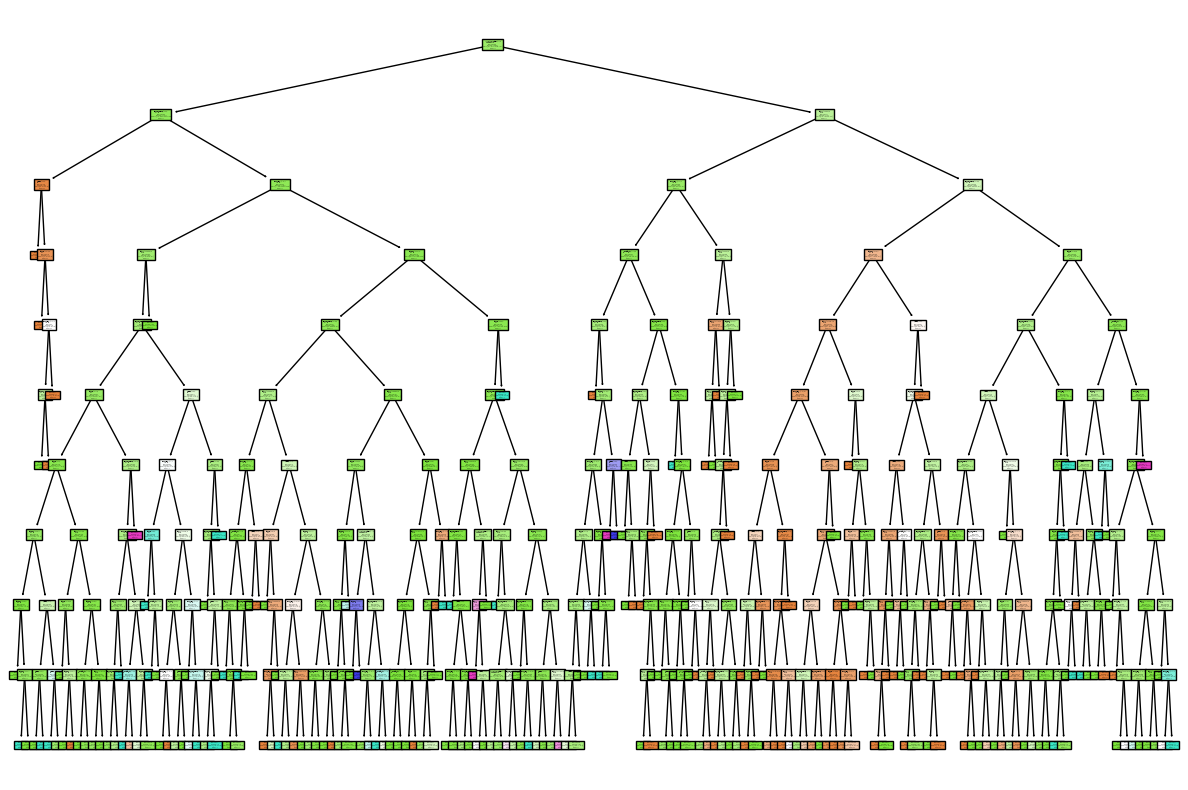

In [17]:
# 랜덤 포레스트의 첫 번째 트리 시각화
estimator = best_rf.estimators_[0]
plt.figure(figsize=(15,10))
tree.plot_tree(estimator, 
               feature_names=X.columns, 
               class_names=y.unique(),
               filled=True)
plt.show()

### 특정 변수(교량연장, 설계활하중, 준공후경과년수), 독립변수 더미 변수화, 그리드 탐색

In [42]:
# 독립변수와 종속변수 분리
X = df[['교량연장', '설계활하중', '준공후경과년수']]  # 독립변수
y = df['최종안전점검결과']  # 종속변수

# 범주형 변수를 더미(dummy) 변수로 변환
X = pd.get_dummies(X)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 탐색할 하이퍼파라미터의 조합 정의
param_grid = {
    'n_estimators': [100, 200, 300],  # 트리 개수
    'max_depth': [None, 5, 10],  # 트리의 깊이
    'min_samples_split': [2, 5, 10],  # 분할을 위한 최소 샘플 수
}

# 랜덤 포레스트 분류기 객체 생성
rf = RandomForestClassifier(random_state=42)

# 그리드 탐색 객체 생성
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# 그리드 탐색 수행
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 조합과 평가 점수 출력
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# 최적의 하이퍼파라미터로 랜덤 포레스트 모델 구축
best_rf = RandomForestClassifier(**grid_search.best_params_)
best_rf.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = best_rf.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best parameters:  {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}
Best score:  0.8480888720331217
Accuracy: 0.8333333333333334


In [43]:
# 중요도 계산
importances = best_rf.feature_importances_

# 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# 중요도 기준으로 내림차순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False, ignore_index=True)

# 상위 10개 변수 출력
top_10_importance = importance_df.head(10)
top_10_importance

,Feature,Importance
0,준공후경과년수,0.494340
1,교량연장,0.489675
2,설계활하중_DB-24,0.006387
3,설계활하중_DB-18,0.003384
4,설계활하중_DB-13.5,0.002818
5,설계활하중_기타,0.002187
6,설계활하중_DB-9,0.001210


### 특정 변수(교량연장, 설계활하중, 준공후경과년수 + 교통량), 독립변수 더미 변수화, 그리드 탐색

In [45]:
# 독립변수와 종속변수 분리
X = df[['교량연장', '설계활하중', '준공후경과년수', '교통량']]  # 독립변수
y = df['최종안전점검결과']  # 종속변수

# 범주형 변수를 더미(dummy) 변수로 변환
X = pd.get_dummies(X)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 탐색할 하이퍼파라미터의 조합 정의
param_grid = {
    'n_estimators': [100, 200, 300],  # 트리 개수
    'max_depth': [None, 5, 10],  # 트리의 깊이
    'min_samples_split': [2, 5, 10],  # 분할을 위한 최소 샘플 수
}

# 랜덤 포레스트 분류기 객체 생성
rf = RandomForestClassifier(random_state=42)

# 그리드 탐색 객체 생성
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# 그리드 탐색 수행
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 조합과 평가 점수 출력
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# 최적의 하이퍼파라미터로 랜덤 포레스트 모델 구축
best_rf = RandomForestClassifier(**grid_search.best_params_)
best_rf.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = best_rf.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best parameters:  {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best score:  0.8704740684554849
Accuracy: 0.8703051643192489


In [46]:
# 중요도 계산
importances = best_rf.feature_importances_

# 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# 중요도 기준으로 내림차순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False, ignore_index=True)

# 상위 10개 변수 출력
top_10_importance = importance_df.head(10)
top_10_importance

,Feature,Importance
0,준공후경과년수,0.364147
1,교량연장,0.316059
2,교통량,0.306757
3,설계활하중_DB-24,0.004692
4,설계활하중_DB-18,0.003166
5,설계활하중_DB-13.5,0.002371
6,설계활하중_기타,0.002062
7,설계활하중_DB-9,0.000747


### 특정 변수(교량연장, 설계활하중, 준공후경과년수 + 시설물종별등급구분, 차로수, 경간수), 독립변수 더미 변수화, 그리드 탐색 

In [47]:
# 독립변수와 종속변수 분리
X = df[['교량연장', '설계활하중', '준공후경과년수', '시설물종별등급구분', '차로수', '경간수']]  # 독립변수
y = df['최종안전점검결과']  # 종속변수

# 범주형 변수를 더미(dummy) 변수로 변환
X = pd.get_dummies(X)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 탐색할 하이퍼파라미터의 조합 정의
param_grid = {
    'n_estimators': [100, 200, 300],  # 트리 개수
    'max_depth': [None, 5, 10],  # 트리의 깊이
    'min_samples_split': [2, 5, 10],  # 분할을 위한 최소 샘플 수
}

# 랜덤 포레스트 분류기 객체 생성
rf = RandomForestClassifier(random_state=42)

# 그리드 탐색 객체 생성
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# 그리드 탐색 수행
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 조합과 평가 점수 출력
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# 최적의 하이퍼파라미터로 랜덤 포레스트 모델 구축
best_rf = RandomForestClassifier(**grid_search.best_params_)
best_rf.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = best_rf.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best parameters:  {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Best score:  0.8556322492967985
Accuracy: 0.8345070422535211


In [48]:
# 중요도 계산
importances = best_rf.feature_importances_

# 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# 중요도 기준으로 내림차순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False, ignore_index=True)

# 상위 10개 변수 출력
top_10_importance = importance_df.head(10)
top_10_importance

,Feature,Importance
0,준공후경과년수,0.432086
1,교량연장,0.282387
2,차로수,0.108750
3,경간수,0.083587
4,시설물종별등급구분_기타,0.046038
5,시설물종별등급구분_2,0.011023
6,시설물종별등급구분_3,0.010666
7,설계활하중_DB-24,0.007769
8,시설물종별등급구분_1,0.005232
9,설계활하중_DB-18,0.004994


### 특정 변수(교량연장, 설계활하중, 준공후경과년수 + 시설물종별등급구분, 차로수, 경간수, 교통량), 독립변수 더미 변수화, 그리드 탐색

In [49]:
# 독립변수와 종속변수 분리
X = df[['교량연장', '설계활하중', '준공후경과년수', '시설물종별등급구분', '차로수', '경간수', '교통량']]  # 독립변수
y = df['최종안전점검결과']  # 종속변수

# 범주형 변수를 더미(dummy) 변수로 변환
X = pd.get_dummies(X)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 탐색할 하이퍼파라미터의 조합 정의
param_grid = {
    'n_estimators': [100, 200, 300],  # 트리 개수
    'max_depth': [None, 5, 10],  # 트리의 깊이
    'min_samples_split': [2, 5, 10],  # 분할을 위한 최소 샘플 수
}

# 랜덤 포레스트 분류기 객체 생성
rf = RandomForestClassifier(random_state=42)

# 그리드 탐색 객체 생성
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# 그리드 탐색 수행
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 조합과 평가 점수 출력
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# 최적의 하이퍼파라미터로 랜덤 포레스트 모델 구축
best_rf = RandomForestClassifier(**grid_search.best_params_)
best_rf.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = best_rf.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best parameters:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best score:  0.8727353749881483
Accuracy: 0.8632629107981221


In [50]:
# 중요도 계산
importances = best_rf.feature_importances_

# 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# 중요도 기준으로 내림차순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False, ignore_index=True)

# 상위 10개 변수 출력
top_10_importance = importance_df.head(10)
top_10_importance

,Feature,Importance
0,준공후경과년수,0.313629
1,교통량,0.241988
2,교량연장,0.206085
3,차로수,0.087157
4,경간수,0.072938
5,시설물종별등급구분_기타,0.034406
6,시설물종별등급구분_2,0.010233
7,시설물종별등급구분_3,0.008936
8,시설물종별등급구분_1,0.008232
9,설계활하중_DB-24,0.006060


# XGBoost

### 모든 변수, 독립변수 더미 변수화, 종속변수 라벨 인코딩

In [51]:
# 독립변수와 종속변수 분리
X = df.drop(['교량명', '최종안전점검결과'], axis=1)
y = df['최종안전점검결과']

# 범주형 변수를 더미(dummy) 변수로 변환
X = pd.get_dummies(X)

# 종속변수 라벨 인코딩 수행
le = LabelEncoder()
y = le.fit_transform(y)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost 모델 생성과 학습
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8673708920187794


In [52]:
# 중요도 계산
importances = model.feature_importances_

# 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# 중요도 기준으로 내림차순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False, ignore_index=True)

# 상위 10개 변수 출력
top_10_importance = importance_df.head(10)
top_10_importance

,Feature,Importance
0,시설물종별등급구분_기타,0.373341
1,준공후경과년수,0.069979
2,상부구조형식_라멘교,0.034184
3,시설물종별등급구분_3,0.033931
4,상부구조형식_PSCI거더교,0.031331
5,교통량,0.030639
6,시설물종별등급구분_1,0.029992
7,상부구조형식_강플레이트거더교,0.028846
8,상부구조형식_프리플렉스거더교,0.028317
9,경간수,0.025846


### 모든 변수, 독립변수 더미 변수화, 종속변수 라벨 인코딩, 그리드 탐색

In [53]:
# 독립변수와 종속변수 분리
X = df.drop(['교량명', '최종안전점검결과'], axis=1)
y = df['최종안전점검결과']

# 범주형 변수를 더미(dummy) 변수로 변환
X = pd.get_dummies(X)
        
# 종속변수 라벨 인코딩 수행
le = LabelEncoder()
y = le.fit_transform(y)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost 모델 생성
model = xgb.XGBClassifier(random_state=42)

# 탐색할 하이퍼파라미터의 조합 정의
param_grid = {
    'n_estimators': [100, 200, 300],  # 트리 개수
    'max_depth': [3, 5, 7],  # 트리의 깊이
    'learning_rate': [0.1, 0.01, 0.001]  # 학습률
}

# 그리드 탐색 객체 생성
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# 그리드 탐색 수행
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 조합과 평가 점수 출력
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# 최적의 하이퍼파라미터로 XGBoost 모델 구축
best_model = grid_search.best_estimator_

# 테스트 데이터로 예측
y_pred = best_model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best score:  0.8739916563951835
Accuracy: 0.8703051643192489


In [54]:
# 중요도 계산
importances =  best_model.feature_importances_

# 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# 중요도 기준으로 내림차순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False, ignore_index=True)

# 상위 10개 변수 출력
top_10_importance = importance_df.head(10)
top_10_importance

,Feature,Importance
0,시설물종별등급구분_기타,0.367213
1,준공후경과년수,0.073866
2,상부구조형식_라멘교,0.047445
3,시설물종별등급구분_1,0.033651
4,시설물종별등급구분_3,0.033076
5,교통량,0.031847
6,상부구조형식_프리플렉스거더교,0.031755
7,상부구조형식_PSCI거더교,0.031430
8,경간수,0.028403
9,교량연장,0.022539


### 특정 변수(교량연장, 설계활하중, 준공후경과년수), 독립변수 더미 변수화, 종속변수 라벨 인코딩, 그리드 탐색

In [55]:
# 독립변수와 종속변수 분리
X = df[['교량연장', '설계활하중', '준공후경과년수']]
y = df['최종안전점검결과']

# 범주형 변수를 더미(dummy) 변수로 변환
X = pd.get_dummies(X)

# 종속변수 라벨 인코딩 수행
le = LabelEncoder()
y = le.fit_transform(y)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost 모델 생성
model = xgb.XGBClassifier(random_state=42)

# 탐색할 하이퍼파라미터의 조합 정의
param_grid = {
    'n_estimators': [100, 200, 300],  # 트리 개수
    'max_depth': [3, 5, 7],  # 트리의 깊이
    'learning_rate': [0.1, 0.01, 0.001]  # 학습률
}

# 그리드 탐색 객체 생성
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# 그리드 탐색 수행
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 조합과 평가 점수 출력
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# 최적의 하이퍼파라미터로 XGBoost 모델 구축
best_model = grid_search.best_estimator_

# 테스트 데이터로 예측
y_pred = best_model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best parameters:  {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300}
Best score:  0.8397885654688537
Accuracy: 0.8309859154929577


In [56]:
# 중요도 계산
importances = best_model.feature_importances_

# 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# 중요도 기준으로 내림차순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False, ignore_index=True)

# 상위 10개 변수 출력
top_10_importance = importance_df.head(10)
top_10_importance

,Feature,Importance
0,준공후경과년수,0.452818
1,교량연장,0.206165
2,설계활하중_DB-24,0.100819
3,설계활하중_DB-18,0.096088
4,설계활하중_기타,0.084056
5,설계활하중_DB-13.5,0.060056
6,설계활하중_DB-9,0.000000


### 특정 변수(교량연장, 설계활하중, 준공후경과년수 + 교통량), 독립변수 더미 변수화, 종속변수 라벨 인코딩, 그리드 탐색

In [57]:
# 독립변수와 종속변수 분리
X = df[['교량연장', '설계활하중', '준공후경과년수', '교통량']]
y = df['최종안전점검결과']

# 범주형 변수를 더미(dummy) 변수로 변환
X = pd.get_dummies(X)

# 종속변수 라벨 인코딩 수행
le = LabelEncoder()
y = le.fit_transform(y)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost 모델 생성
model = xgb.XGBClassifier(random_state=42)

# 탐색할 하이퍼파라미터의 조합 정의
param_grid = {
    'n_estimators': [100, 200, 300],  # 트리 개수
    'max_depth': [3, 5, 7],  # 트리의 깊이
    'learning_rate': [0.1, 0.01, 0.001]  # 학습률
}

# 그리드 탐색 객체 생성
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# 그리드 탐색 수행
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 조합과 평가 점수 출력
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# 최적의 하이퍼파라미터로 XGBoost 모델 구축
best_model = grid_search.best_estimator_

# 테스트 데이터로 예측
y_pred = best_model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Best score:  0.8707256407825291
Accuracy: 0.8644366197183099


In [58]:
# 중요도 계산
importances = best_model.feature_importances_

# 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# 중요도 기준으로 내림차순 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False, ignore_index=True)

# 상위 10개 변수 출력
top_10_importance = importance_df.head(10)
top_10_importance

,Feature,Importance
0,준공후경과년수,0.327763
1,교량연장,0.164096
2,교통량,0.160270
3,설계활하중_DB-13.5,0.122260
4,설계활하중_DB-24,0.095947
5,설계활하중_DB-18,0.076739
6,설계활하중_기타,0.052924
7,설계활하중_DB-9,0.000000
